In [13]:
from icevision.all import *
import os

In [23]:
# define 
annotations_pth = 'data/predictions_template.json'
images_dir = 'data/images'
parser = parsers.COCOBBoxParser(annotations_filepath = annotations_pth, img_dir = images_dir)
train_records, valid_records = parser.parse(data_splitter=RandomSplitter([0.,1.]))

0it [00:00, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [24]:
# define image size and transformations (size and normalization should match training settings)
image_size = 384
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])
valid_ds = Dataset(valid_records, valid_tfms)

In [25]:
# create baseline model
import torch
import torchvision
from icevision import models

# Run the model on GPU if it is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load a pre-trained Faster R-CNN model
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes=30)
model_type = models.torchvision.faster_rcnn
model = model_type.model(num_classes=len(parser.class_map))
model.to(device)

print("Model ready")

Model ready


In [26]:
# create dataloader
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

In [27]:
# create fastai learner and load trained weights
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

learn = model_type.fastai.learner(dls=[valid_dl], model=model, metrics=metrics)
learn.load('baseline_model')

In [29]:
# prepare image records

import glob
from PIL import Image
import tqdm

with open(annotations_pth) as f:
    template_coco = json.load(f)

img_fns = [img['file_name'] for img in template_coco['images']]

records = []
for i,pth in tqdm.tqdm(enumerate(img_fns)):
    img = Image.open(f'{images_dir}/{pth}')
    npimg = np.array(img)
    if len(npimg.shape) < 3:
        npimg = np.repeat(npimg[...,np.newaxis],3, axis=2)
    record = BaseRecord((ImageRecordComponent(),))
    record.set_record_id(i)
    record.set_img(npimg)
    valid_tfms(record)
    record.add_component(FilepathRecordComponent())
    record.set_filepath(f'{images_dir}/{pth}')
    records.append(record)
    img.close()

531it [00:04, 115.48it/s]


In [30]:
# create validation dataloader

test_ds = Dataset(records, valid_tfms)
test_dl = model_type.infer_dl(test_ds, batch_size=1, num_workers=4, shuffle=False)

In [31]:
# perform prediction

from tqdm import tqdm
model.eval()

preds = []
with torch.no_grad():
    for sample in tqdm(test_dl):
        img, record = sample   
        img = img[0].to(device)
        pred = model(img)[0]
        pred['boxes'] = pred['boxes'].cpu().detach().numpy()
        pred['labels'] = pred['labels'].cpu().detach().numpy()
        pred['scores'] = pred['scores'].cpu().detach().numpy()
        preds.append((pred, record[0].common.filepath))

100%|██████████| 531/531 [00:11<00:00, 45.75it/s]


In [35]:
#create coco json
from torchvision.transforms import functional as func
import json

    
imgs = []
img_path_to_id = {}
anns = []
cats = template_coco['categories']

for pred, filepath in preds:
    
    # find original image dimensions
    original_img = Image.open(filepath)
    original_img = func.to_tensor(original_img)
    _, h, w = original_img.shape
    max_side_length = max(h, w)
    scale_factor = max_side_length / image_size
    y_offset = (max_side_length - h) // 2.0
    x_offset = (max_side_length - w) // 2.0
    
    #create and add image array entry
    img_id = len(imgs) + 1
    img_path_to_id[filepath] = img_id
    img_entry = {
        'id': img_id,
        'file_name': str(filepath),
        'width': w,
        'height': h
    }
    imgs.append(img_entry)
    
    #add annotations
    for box, label, score in zip(pred['boxes'], pred['labels'], pred['scores']):
         # print(box)
        box = box * scale_factor
        # print(box)
        x1, y1, x2, y2 = box
        x1 = x1 - x_offset
        x2 = x2 - x_offset
        y1 = y1 - y_offset
        y2 = y2 - y_offset
    
        scaled_box = [x1 , y1 , (x2 - x1) , (y2 - y1) ]
        scaled_box = list(map(int, scaled_box))
        area = scaled_box[2] * scaled_box[3]
        
        ann_id = len(anns) + 1
        ann_entry = {
            'id': int(ann_id),
            'image_id': int(img_id),
            'category_id': int(label),
            'bbox': scaled_box,
            'area': area,
            'segmentation': [],
            'score': float(score)
        }
        anns.append(ann_entry)      

In [37]:
# save predictions json
results_name = 'baseline_predictions.json'
results_json = {
    'images': imgs,
    'annotations': anns,
    'categories': cats
}
with open(results_name, 'w') as f:
    json.dump(results_json, f)

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


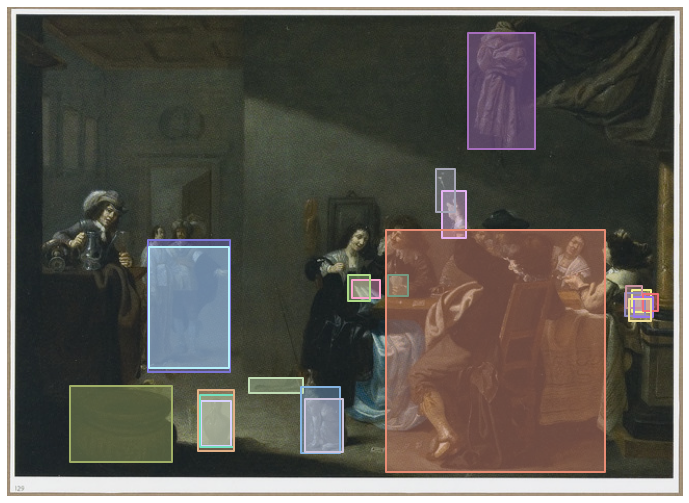

In [49]:
# inspect generated predictions
import skimage.io as io

from pycocotools.coco import COCO
coco = COCO(results_name)

test_img = results_json['images'][150]

img_path = test_img['file_name']

I = io.imread(img_path)
# load and display instance annotations
plt.figure(figsize=(16, 9)); plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=test_img['id'], catIds=[], iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox=True)

In [4]:
import fastai
print(fastai)

<module 'fastai' from '/localhome/mathias/.conda/envs/submission/lib/python3.9/site-packages/fastai/__init__.py'>
